In [14]:
%pip install nltk
%pip install tensorflow
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [15]:
# Importar bibliotecas necesarias para el procesamiento de texto
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import seaborn as sns

# Importar las bibliotecas necesarias desde TensorFlow para el modelo RNN
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.layers import Dropout

# Importar bibliotecas necesarias de Scikit-learn para dividir los datos
from sklearn.model_selection import train_test_split

# Importar bibliotecas necesarias para la manipulación de datos y vectores
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import pandas as pd


# Importar bibliotecas necesarias para trabajar con el modelo
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.utils import to_categorical


In [16]:
# Descargar recursos necesarios de NLTK
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to C:\Users\Laura
[nltk_data]    |     Rodríguez\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to C:\Users\Laura
[nltk_data]    |     Rodríguez\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\Laura
[nltk_data]    |     Rodríguez\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     C:\Users\Laura
[nltk_data]    |     Rodríguez\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptr

True

In [17]:
# Cargar el archivo CSV
data_path = '../data/Sentimiento.csv'
df = pd.read_csv(data_path)

In [18]:
# Visualizar las primeras filas y la estructura del dataset
print(df.head())
print(df.info())

   id                                              texto sentimiento
0   0  ChatGPT: Optimizing Language Models for Dialog...     neutral
1   1  Try talking with ChatGPT, our new AI system wh...        good
2   2  ChatGPT: Optimizing Language Models for Dialog...     neutral
3   3  THRILLED to share that ChatGPT, our new model ...        good
4   4  As of 2 minutes ago, @OpenAI released their ne...         bad
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219294 entries, 0 to 219293
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           219294 non-null  int64 
 1   texto        219294 non-null  object
 2   sentimiento  219294 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.0+ MB
None


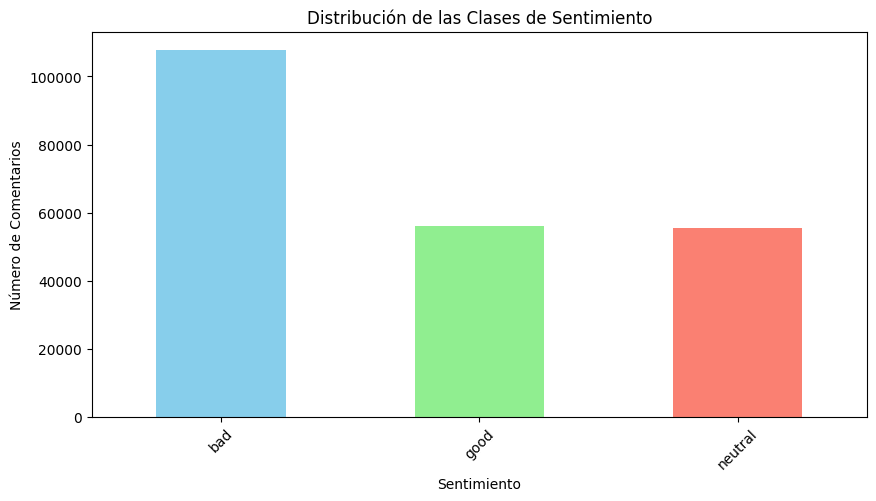

In [19]:
# Visualizar la distribución de las clases de sentimiento
sentiment_counts = df['sentimiento'].value_counts()
plt.figure(figsize=(10, 5))
sentiment_counts.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Distribución de las Clases de Sentimiento')
plt.xlabel('Sentimiento')
plt.ylabel('Número de Comentarios')
plt.xticks(rotation=45)
plt.show()

In [20]:
# Función de preprocesamiento de texto
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Eliminar menciones y hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    # Eliminar números
    text = re.sub(r'\d+', '', text)
    # Eliminar caracteres especiales
    text = re.sub(r'\W', ' ', text)
    # Eliminar espacios extra
    text = re.sub(r'\s+', ' ', text).strip()
    # Tokenización
    tokens = word_tokenize(text)
    # Lematización y eliminación de palabras vacías
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(filtered_tokens)

# Aplicar el preprocesamiento al texto
df['texto_preprocesado'] = df['texto'].apply(preprocess_text)

# Visualizar las primeras filas del dataset preprocesado
print(df[['texto', 'texto_preprocesado', 'sentimiento']].head())

                                               texto  \
0  ChatGPT: Optimizing Language Models for Dialog...   
1  Try talking with ChatGPT, our new AI system wh...   
2  ChatGPT: Optimizing Language Models for Dialog...   
3  THRILLED to share that ChatGPT, our new model ...   
4  As of 2 minutes ago, @OpenAI released their ne...   

                                  texto_preprocesado sentimiento  
0         chatgpt optimizing language model dialogue     neutral  
1  try talking chatgpt new ai system optimized di...        good  
2  chatgpt optimizing language model dialogue n n...     neutral  
3  thrilled share chatgpt new model optimized dia...        good  
4   minute ago released new chatgpt n nand use right         bad  


In [21]:
# Tokenización y secuencias
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(df['texto_preprocesado'])
secuencias = tokenizer.texts_to_sequences(df['texto_preprocesado'])

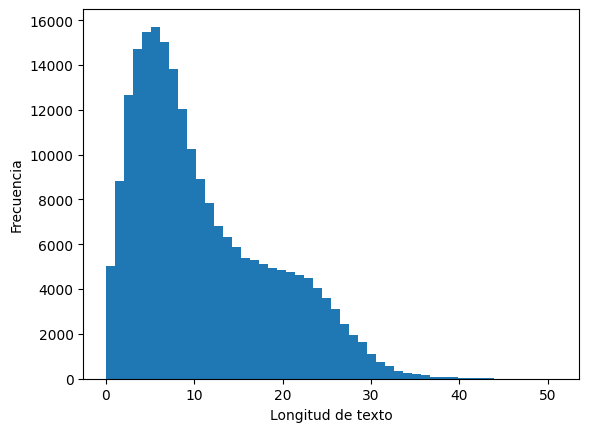

In [22]:
longitudes = [len(seq) for seq in secuencias]
plt.hist(longitudes, bins=50)
plt.xlabel('Longitud de texto')
plt.ylabel('Frecuencia')
plt.show()

In [23]:
# Padding para que todas las secuencias tengan la misma longitud
max_length = 30  # Ajustable según tus datos
secuencias_padded = pad_sequences(secuencias, maxlen=max_length)

# Convertir las etiquetas 'bad', 'good', 'neutral' a valores numéricos (0, 1, 2)
df['sentimiento'] = df['sentimiento'].map({'bad': 0, 'neutral': 1, 'good': 2})

# Convertir las etiquetas a one-hot encoding
y = to_categorical(df['sentimiento'], num_classes=3)  # 3 clases (bad, good, neutral)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(secuencias_padded, y, test_size=0.2, random_state=42)

"""# Aplicar SMOTE para balancear las clases en el conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train.argmax(axis=1))

# Convertir las etiquetas balanceadas de nuevo a one-hot encoding
y_train_balanced = to_categorical(y_train_balanced, num_classes=3)"""

'# Aplicar SMOTE para balancear las clases en el conjunto de entrenamiento\nsmote = SMOTE(random_state=42)\nX_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train.argmax(axis=1))\n\n# Convertir las etiquetas balanceadas de nuevo a one-hot encoding\ny_train_balanced = to_categorical(y_train_balanced, num_classes=3)'

In [24]:
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

# Definir el modelo RNN para clasificación multiclase
model = Sequential()
model.add(Embedding(input_dim=20000, output_dim=64))
model.add(SimpleRNN(units=128, return_sequences=False))
model.add(Dense(3, activation='softmax'))

# Ajustar el learning rate del optimizador Adam
optimizer = Adam(learning_rate=0.0001)

# Compilar el modelo con categorical_crossentropy para clasificación multiclase
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()

# Definir EarlyStopping para detener el entrenamiento cuando el modelo deje de mejorar
early_stopper = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [25]:
print(f"Valor máximo en X_train: {X_train.max()}")
print(f"Valor máximo en X_test: {X_test.max()}")
print(f"Valor mínimo en X_train: {X_train.min()}")
print(f"Valor mínimo en X_test: {X_test.min()}")


Valor máximo en X_train: 19999
Valor máximo en X_test: 19998
Valor mínimo en X_train: 0
Valor mínimo en X_test: 0


In [26]:
# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=512, validation_data=(X_test, y_test), callbacks=[early_stopper])

Epoch 1/20
343/343 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5253 - loss: 0.9819 - val_accuracy: 0.6557 - val_loss: 0.7569
Epoch 2/20
343/343 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.7097 - loss: 0.6663 - val_accuracy: 0.7887 - val_loss: 0.5426
Epoch 3/20
343/343 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.8197 - loss: 0.4786 - val_accuracy: 0.8273 - val_loss: 0.4582
Epoch 4/20
343/343 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.8650 - loss: 0.3883 - val_accuracy: 0.8482 - val_loss: 0.4121
Epoch 5/20
343/343 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.8941 - loss: 0.3312 - val_accuracy: 0.8721 - val_loss: 0.3775
Epoch 6/20
343/343 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.9113 - loss: 0.2898 - val_accuracy: 0.8791 - val_loss: 0.3617
Epoch 7/20
343/343 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.9228 - loss: 0.2646 - val_accuracy: 0.8884 - val_loss: 0.3639
Epoch 8/20
343/343 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.9319 - loss: 0.2420 - val_acc

In [27]:
# Ejemplo de predicción
new_texts = ["I dislike this movie", "This film is fantastic"]
new_sequences = tokenizer.texts_to_sequences(new_texts)
X_new = pad_sequences(new_sequences, maxlen=max_length)
predictions = model.predict(X_new)

# Mostrar las probabilidades de las predicciones
print(predictions)

# Convertir las probabilidades a la clase más probable
predicted_classes = np.argmax(predictions, axis=1)
print("Clases predichas:", predicted_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
[[9.9367249e-01 6.3044759e-03 2.2984452e-05]
 [3.0044619e-02 3.7276173e-01 5.9719360e-01]]
Clases predichas: [0 2]


1371/1371 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


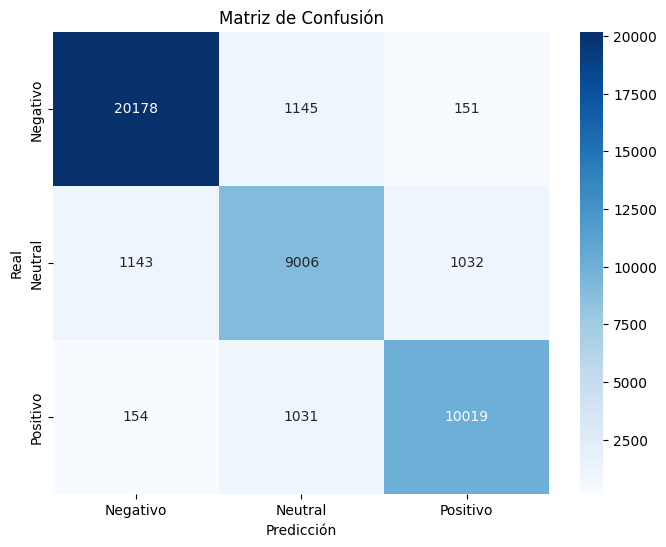

In [28]:
# Evaluar el modelo
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Crear la matriz de confusión
cm = confusion_matrix(y_test_classes, y_pred)

# Crear un gráfico de calor para visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Neutral', 'Positivo'], yticklabels=['Negativo', 'Neutral', 'Positivo'])

# Agregar títulos y etiquetas
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

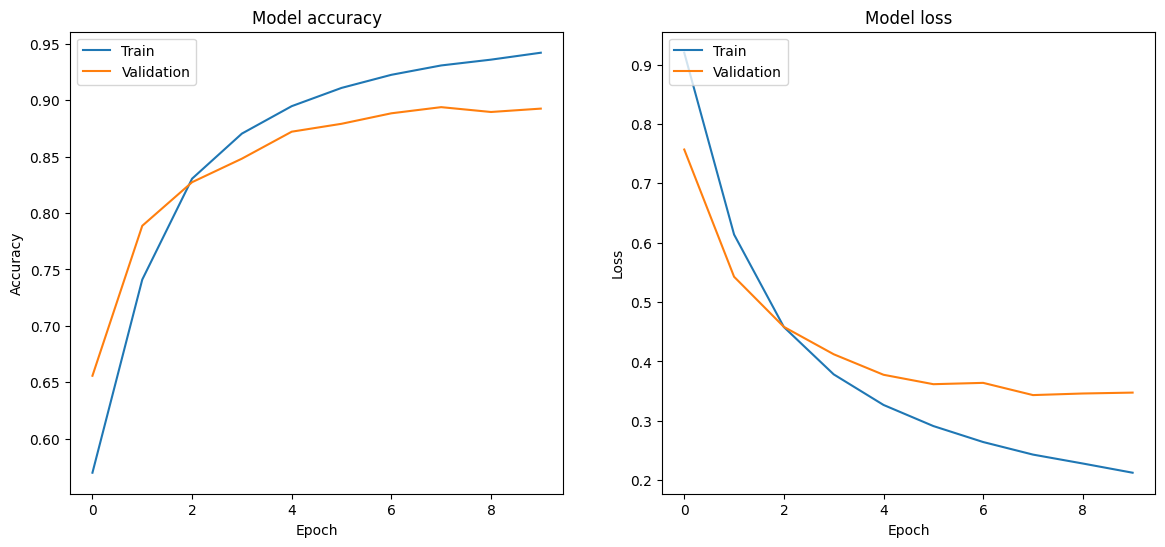

In [29]:
# Gráficas de precisión y pérdida durante el entrenamiento y la validación
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.show()

plot_training_history(history)